### **Question 1**

In [ ]:
#This code is to detect carrots from the  live feed but doesnt work with laptop cam.

# This code has to be downloaded and executed with VS code with your webcam for checking if it works with OpenCV.

import cv2 #use Opencv to connect to live feed
import datetime
cap = cv2.VideoCapture(0) # check webcam on Google server

#process N frames
frame_skip = 10
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count % frame_skip == 0:
        # Process this frame
        carrot_detected = detect_carrot(frame)
        if carrot_detected:
          log_carrot_detection(frame)
    frame_count += 1

    #formatting the frame according to the model
    def preprocess_frame(frame):
      resized = cv2.resize(frame, (224, 224))
      normalized = resized / 255.0
      return normalized.reshape(1, 224, 224, 3)

    #carrot detection
    def detect_carrot(frame):
      preprocessed = preprocess_frame(frame)
      prediction = model.predict(preprocessed)
      return prediction[0] > 0.5

    # recording all detections as images
    def log_carrot_detection(frame):
      timestamp = datetime.datetime.now().isoformat()
      filename = f"carrot_{timestamp}.jpg"
      cv2.imwrite(f"detected/{filename}", frame)
      print(f"[{timestamp}] Carrot detected → saved as {filename}")

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# we can use JavaScript to capture a photo from laptop cam  and then process using
# using the detection model
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
from io import BytesIO
import cv2
import numpy as np


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture Photo';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        return canvas.toDataURL('image/jpeg', quality);
      }
      takePhoto({quality: %s});
    ''' % quality)

    display(js)
    data = eval_js('takePhoto(%f)' % quality)
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

image_path = take_photo()
print("Saved to:", image_path)

image = cv2.imread(image_path)
from google.colab.patches import cv2_imshow
cv2_imshow(image)


Javascript can be used to access webcam and provide a live video stream but there is a limitation. Google Colab doesnt support true real time video feed from webcam to python. It can only process one frame at a time and return it to Python as an image.

What to do is first show a live webcam view using Javascript. Then click on Capture button to take a snapshot and then send the frame to Python detect_carrots(image) function and repeat this step to form a slow stream

In [ ]:
# 1. Camera capture setup
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
from google.colab.patches import cv2_imshow

# 2. Function to capture a photo from webcam
def take_photo(quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    display(js)
    data = eval_js('takePhoto(%f)' % quality)
    binary = b64decode(data.split(',')[1])
    image = Image.open(BytesIO(binary)).convert('RGB')
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# 3. carrot detector
def detect_carrots(image):
    import random
    return random.choice([True, False])

# 4. Run loop manually
while True:
    print("Capture a frame (click the button)...")
    img = take_photo()
    cv2_imshow(img)

    if detect_carrots(img):
        print("Carrot detected!")
    else:
        print("No carrot detected.")

    again = input("Press Enter to continue or type 'q' to quit: ")
    if again.lower() == 'q':
        break


## **Question 2 - **Toy implementation of a classification problem using scikit-learn **

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
print("Classes:", iris.target_names)
print("Feature :", iris.feature_names)
print("Shape of X:", X.shape)

Classes: ['setosa' 'versicolor' 'virginica']
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Shape of X: (150, 4)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
model = LogisticRegression(multi_class='ovr', solver='liblinear')
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr', solver='liblinear')

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



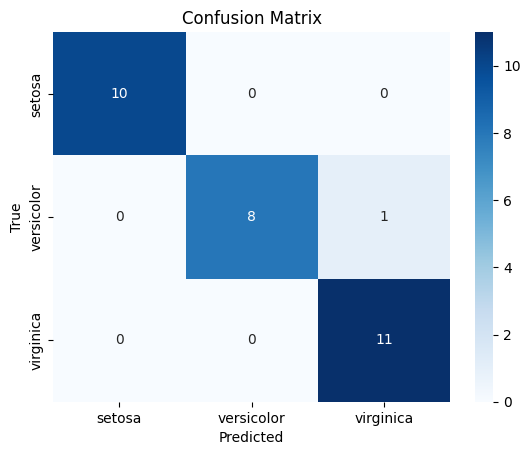

In [5]:
y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, xticklabels=iris.target_names, yticklabels=iris.target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()